# **Import Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

import re
import nltk
nltk.download('punkt_tab')

from sklearn.model_selection import train_test_split

import stanza
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nlp_id.lemmatizer import Lemmatizer
from nlp_id.tokenizer import Tokenizer
from nlp_id.stopword import StopWord

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_colwidth", None)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alicia.siahaya/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
import os
os.chdir("..")

# **Load and Prepare Data**

In [3]:
url = (
    "https://docs.google.com/spreadsheets/d/e/2PACX-1vQx0P59eV_KGGFJe-l86dgsz9pZRehTRJoOP_tyVXbrQPtzmD97E1lZ0lgFJ-ATVTT9HkBRX5g1kRKB/pub?output=csv"
)
df = pd.read_csv(url)
print(df.shape)

(302, 7)


In [4]:
df.head()

,Timestamp,Asal Kampus,Jurusan,Kota Asal Universitas,Tahun Masuk Kuliah,Apa yang Anda sukai selama masa perkuliahan Anda?,Apa yang Anda tidak sukai selama masa perkuliahan Anda?
0,17/04/2025 11:19:12,Universitas Bina Nusantara,Data Science,Jakarta Barat,2022,Saya suka materi yang sudah disiapkan oleh pihak kampus karena memudahkan mahasiswa. Saya juga menyukai program enrichment yang disediakan kampus saya sehingga mahasiswa dapat belajar di ruang lingkup yang lebih luas.,Saya tidak menyukai lingkungan kampus yang macet dan jalanan yang tidak nyaman untuk pejalan kaki. Sehingga seringkali saya telat masuk kelas.
1,20/04/2025 13:19:07,Binus,Data Science,Jakarta,2022,bisa bertemu dengan teman-teman baru dan mendapatkan koneksi. Serta mendapatkan pelajaran yang berguna bagi saya kedepannya.,"kurang suka sama wc nya, kadang bau dan gaada tissue. kurang suka juga sama parkiran dan jalanan sekitar kampus yang sempit dan minim parkir."
2,20/04/2025 13:21:43,Universitas Bina Nusantara,Data Science,Jakarta,2022,Saya suka dengan makanan yang ada di dalam kampus saya terutama bakmi efata. Selain itu disekitar kampus juga banyak makanan enak.,saya tidak suka gedung parkir kampus saya karena kecil dan sering banget macet. kalau pulang kadang bisa sampai 1 jam
3,20/04/2025 13:28:18,BINUS,Computer Science,Tangerang,2020,Fasilitas kampus Alam Sutera sangat bagus. Pelajaran lab diajarkan oleh asisten yang sangat mengerti materi.,"Dosen sering memberi nilai sesuai keinginan tanpa penilaian yang jelas. Biaya kuliah sangat mahal. Walaupun fasilitas komputer memiliki spesifikasi tinggi, mouse dan keyboard adalah yang paling murah sehingga tidak nyaman digunakan."
4,20/04/2025 13:34:06,Bina Nusantara,Data Science,Jakarta,2022,"Saya suka dengan pertemanannya solid mau saling bantu satu sama lain, bagi bagi kisi kisi pas ujian trs saling ngajarin.","Saya ga suka jam kuliahnya ga bisa milih sendiri, jadi waktunya ga fleksibel buat nyari kerja part time trs jg buat main"


In [5]:
df_melt = df.melt(
    value_vars=[
        "Apa yang Anda sukai selama masa perkuliahan Anda?",
        "Apa yang Anda tidak sukai selama masa perkuliahan Anda?"
    ],
    var_name='sentiment',
    value_name='text'
)

sentiment_map = {
    "Apa yang Anda sukai selama masa perkuliahan Anda?": 'positive',
    "Apa yang Anda tidak sukai selama masa perkuliahan Anda?": 'negative'
}
df_melt['sentiment'] = df_melt['sentiment'].map(sentiment_map)

df_preprocess = df_melt[['text', 'sentiment']]

In [6]:
df_preprocess.head()

,text,sentiment
0,Saya suka materi yang sudah disiapkan oleh pihak kampus karena memudahkan mahasiswa. Saya juga menyukai program enrichment yang disediakan kampus saya sehingga mahasiswa dapat belajar di ruang lingkup yang lebih luas.,positive
1,bisa bertemu dengan teman-teman baru dan mendapatkan koneksi. Serta mendapatkan pelajaran yang berguna bagi saya kedepannya.,positive
2,Saya suka dengan makanan yang ada di dalam kampus saya terutama bakmi efata. Selain itu disekitar kampus juga banyak makanan enak.,positive
3,Fasilitas kampus Alam Sutera sangat bagus. Pelajaran lab diajarkan oleh asisten yang sangat mengerti materi.,positive
4,"Saya suka dengan pertemanannya solid mau saling bantu satu sama lain, bagi bagi kisi kisi pas ujian trs saling ngajarin.",positive


# **Exploratory Data Analysis**

## **EDA Persebaran Responden**

In [7]:
df_demografis = df[['Asal Kampus', 'Jurusan', 'Kota Asal Universitas', 'Tahun Masuk Kuliah']]

### **Standardisasi nama universitas dan jurusan**

In [8]:
from src.dictionary.mapping_dictionary import university_mapping
from src.dictionary.mapping_dictionary import city_mapping
from src.dictionary.mapping_dictionary import program_mapping

def standardize_university_name(name):
    """
        Applying standardization to university name: 
        - Convert to lowercase
        - Remove punctuation, 'the', 'and'
        - Remove extra spaces
    """
    if pd.isna(name):
        return name
    name = str(name).lower()
    name = re.sub(r'[^\w\s]', '', name) 
    name = re.sub(r'\bthe\b', '', name) 
    name = re.sub(r'\band\b', '', name) 
    name = re.sub(r'\s+', ' ', name).strip() 
    return name

def apply_mapping(text, mapping_dict):
    if not isinstance(text, str):
        return None
    text_lower = text.lower()
    for pattern, mapped_value in mapping_dict.items():
        if re.search(pattern, text_lower, flags=re.IGNORECASE):
            return mapped_value
    return None  # No match found

In [9]:
df_demografis['Asal Kampus'] = df_demografis['Asal Kampus'].apply(standardize_university_name)

df_demografis['Mapped_University'] = df_demografis['Asal Kampus'].apply(lambda x: apply_mapping(x, university_mapping))
df_demografis['Mapped_City'] = df_demografis['Kota Asal Universitas'].apply(lambda x: apply_mapping(x, city_mapping))
df_demografis['Mapped_Program'] = df_demografis['Jurusan'].apply(lambda x: apply_mapping(x, program_mapping))

Memastikan seluruh asal kampus, nama universitas dan jurusan sudah terstandarisasi. 

In [10]:
unmapped_universities = df_demografis[df_demografis['Mapped_University'].isna()]['Asal Kampus'].unique()
unmapped_cities = df_demografis[df_demografis['Mapped_City'].isna()]['Kota Asal Universitas'].unique()
unmapped_programs = df_demografis[df_demografis['Mapped_Program'].isna()]['Jurusan'].unique()

print(f"\nUnmapped universities ({len(unmapped_universities)}):")
for u in unmapped_universities:
    print(f"- {u}")

print(f"\nUnmapped cities ({len(unmapped_cities)}):")
for c in unmapped_cities:
    print(f"- {c}")

print(f"\nUnmapped programs ({len(unmapped_programs)}):")
for p in unmapped_programs:
    print(f"- {p}")


Unmapped universities (0):

Unmapped cities (0):

Unmapped programs (0):


## **Functions for plots**

In [11]:
def plot_distribution(df, column, title, threshold=None,
                      color='skyblue', xlabel='Kategori', ylabel='Jumlah',
                      show_percentage=True, sort_index=False):

    counts = df[column].value_counts()
    if sort_index:
        counts = counts.sort_index()

    total = counts.sum()

    if threshold is not None:
        main = counts[counts / total >= threshold]
        others = counts[counts / total < threshold].sum()
        if others > 0:
            counts = pd.concat([main, pd.Series({'Others': others})])

    labels = counts.index.astype(str)
    sizes = counts.values
    percentages = (sizes / total * 100).round(1)

    # Plot
    plt.figure(figsize=(12, 10))
    bars = plt.bar(labels, sizes, color=color, edgecolor='black')

    for bar, size, pct in zip(bars, sizes, percentages):
        label = f'{pct:.1f}% ({size})' if show_percentage else f'{size}'
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                 label, ha='center', va='bottom', fontsize=12)

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=20)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=90, ha='right', fontsize=14)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_wordcloud(df, sentiment, column_name, plot_title): 
    texts = df[df['sentiment'] == sentiment][column_name]
    
    all_tokens = []
    for text in texts:
        tokens = [token.strip() for token in str(text).split() if token.strip()]
        all_tokens.extend(tokens)

    combined_text = ' '.join(all_tokens)
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        random_state=42,
    ).generate(combined_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(plot_title, fontsize=16)
    plt.show()


## **Plot distribusi responden**

### **1. Persebaran Responden berdasarkan Universitas**

Jumlah Universitas: 34


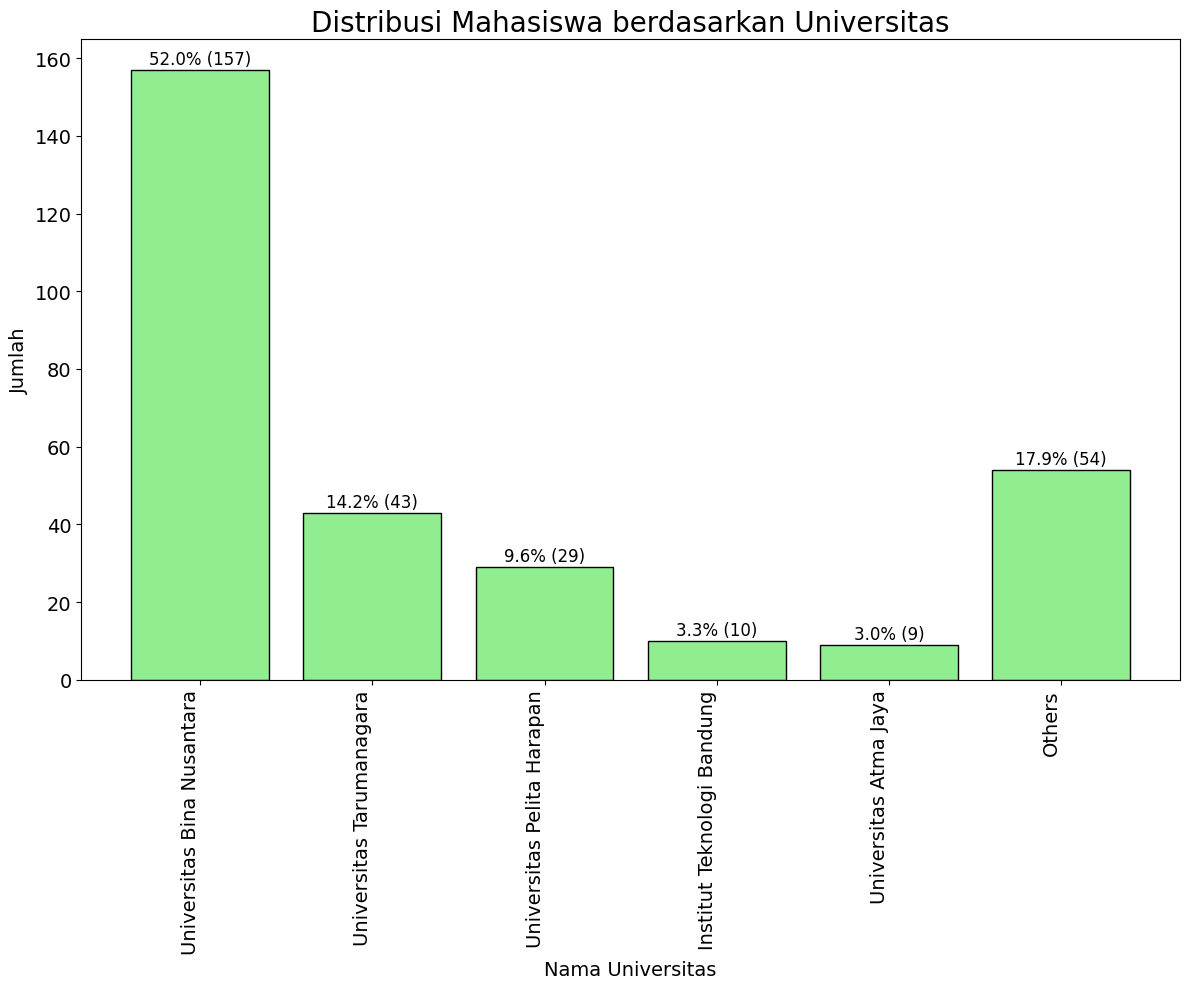

In [13]:
count_unique_university = df_demografis['Mapped_University'].nunique()
print("Jumlah Universitas:", count_unique_university)
plot_distribution(df_demografis,
                  column='Mapped_University',
                  title='Distribusi Mahasiswa berdasarkan Universitas',
                  threshold=0.025,
                  color='lightgreen',
                  xlabel='Nama Universitas',
                  sort_index=False)

### **2. Persebaran Responden berdasarkan Tahun Masuk Kuliah**

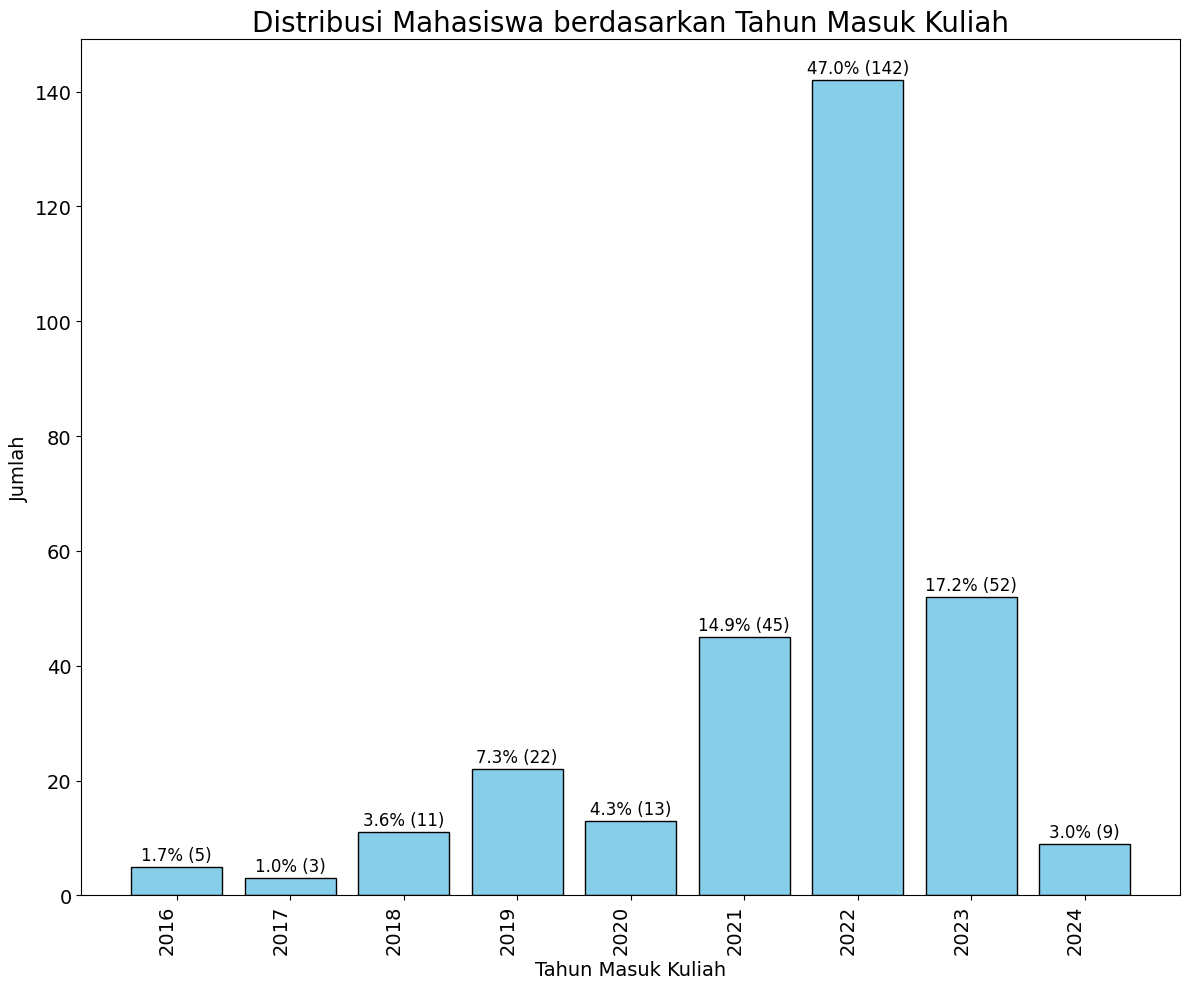

In [14]:
plot_distribution(df_demografis,
                  column='Tahun Masuk Kuliah',
                  title='Distribusi Mahasiswa berdasarkan Tahun Masuk Kuliah',
                  threshold=None,
                  color='skyblue',
                  xlabel='Tahun Masuk Kuliah',
                  sort_index=True)

### **3. Persebaran Responden berdasarkan Asal Kota Universitas**

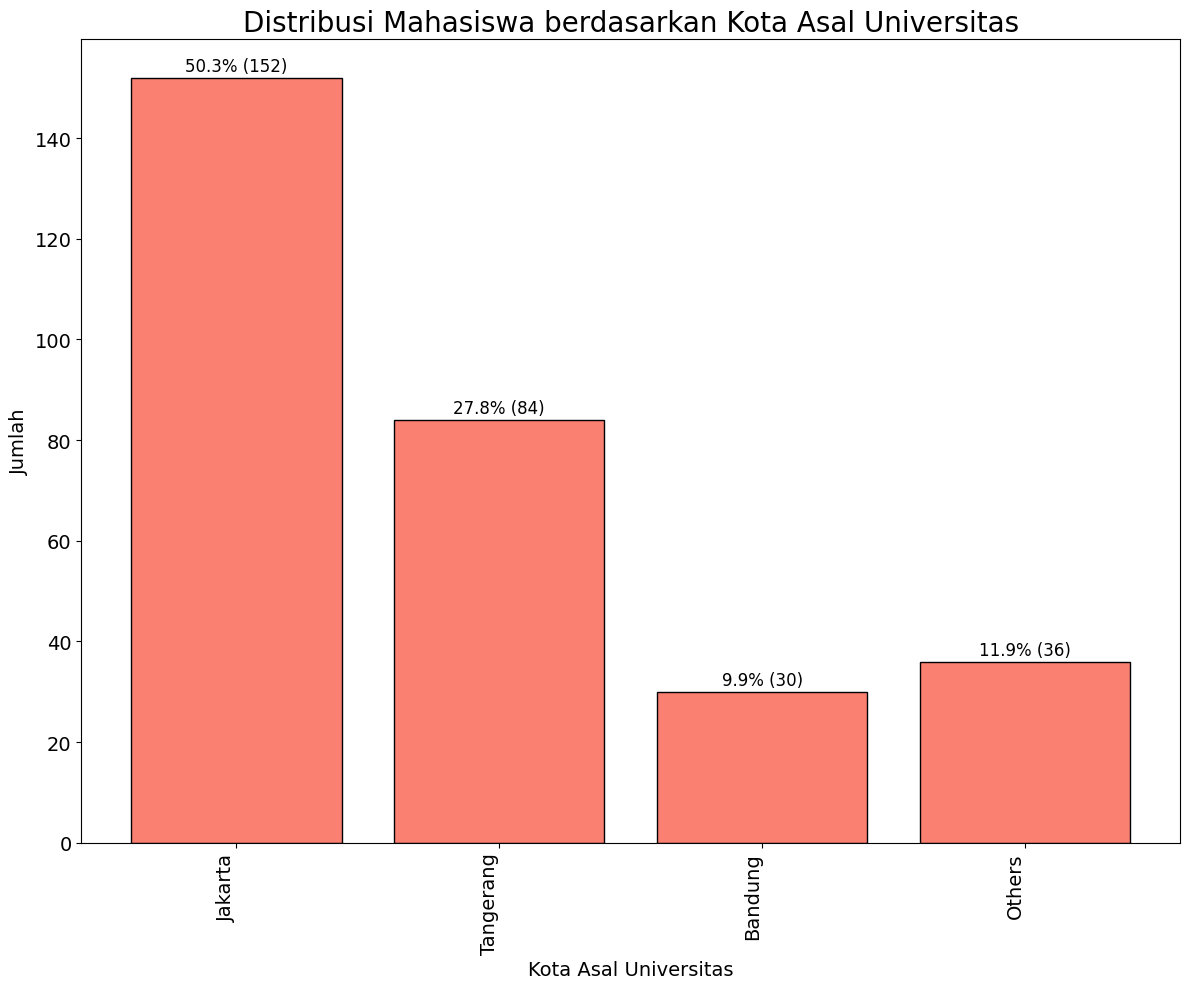

In [15]:
plot_distribution(df_demografis,
                  column='Mapped_City',
                  title='Distribusi Mahasiswa berdasarkan Kota Asal Universitas',
                  threshold=0.05,
                  color='salmon',
                  xlabel='Kota Asal Universitas',
                  sort_index=False)

### **4. Persebaran Responden berdasarkan Jurusan**

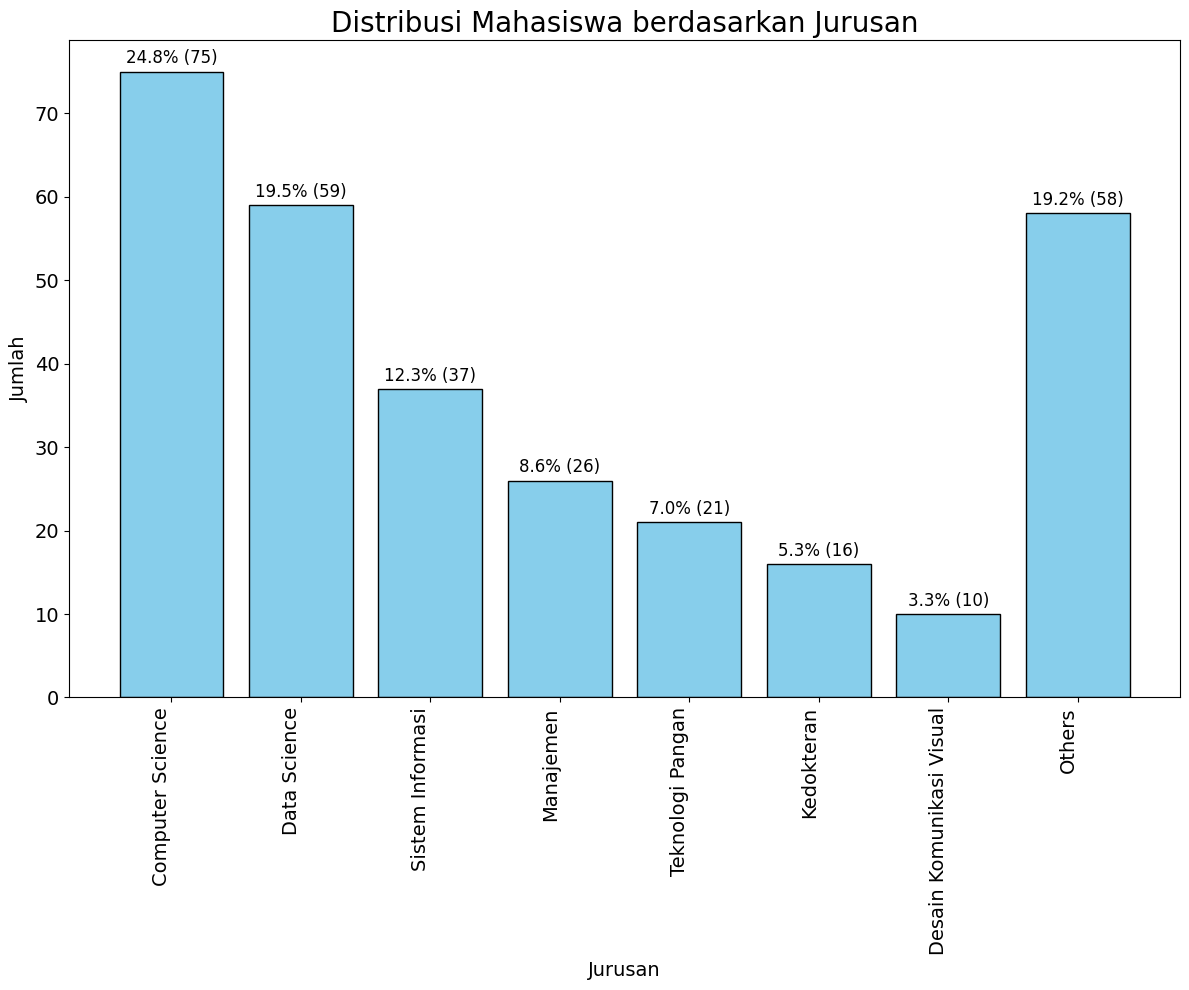

In [16]:
plot_distribution(df_demografis,
                  column='Mapped_Program',
                  title='Distribusi Mahasiswa berdasarkan Jurusan',
                  threshold=0.03,
                  color='skyblue',
                  xlabel='Jurusan',
                  sort_index=False)

## **EDA sebelum Preprocessing**

In [17]:
df_preprocess['word_count'] = df_preprocess['text'].apply(lambda x: len(str(x).split()))

mean_word_count = df_preprocess['word_count'].mean()
print("Rata-rata jumlah kata per ulasan:", mean_word_count)

Rata-rata jumlah kata per ulasan: 26.95860927152318


In [18]:
mean_word_count = df_preprocess.groupby('sentiment')['word_count'].mean()
print("Rata-rata jumlah kata per", mean_word_count)

Rata-rata jumlah kata per sentiment
negative    27.920530
positive    25.996689
Name: word_count, dtype: float64


In [19]:
all_words = [word for tokens in df_preprocess['text'] for word in tokens]

unique_words = set(all_words)
num_unique_words = len(unique_words)

print(f"Jumlah kata unik: {num_unique_words}")

Jumlah kata unik: 79


### **1. WordCloud**

#### WordCloud untuk seluruh sentimen

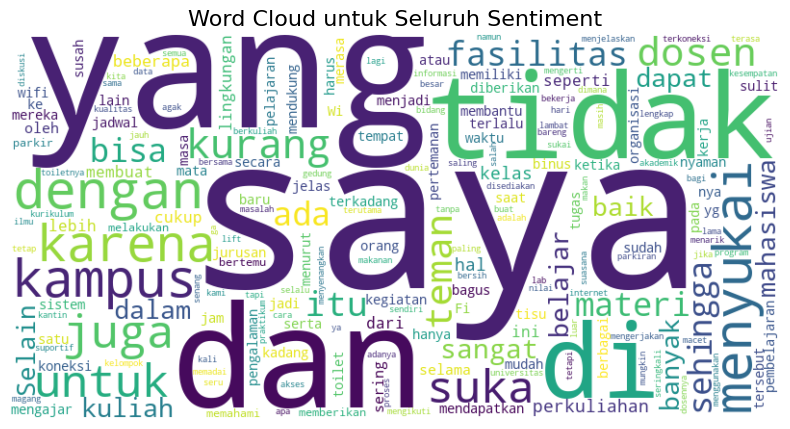

In [20]:
texts = df_preprocess['text']

all_tokens = []
for text in texts:
    tokens = [token.strip() for token in str(text).split() if token.strip()]
    all_tokens.extend(tokens)
combined_text = ' '.join(all_tokens)

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    random_state=42,
    collocations=False
).generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud untuk Seluruh Sentiment", fontsize=16)
plt.show()

#### WordCloud untuk sentimen positif dan negatif

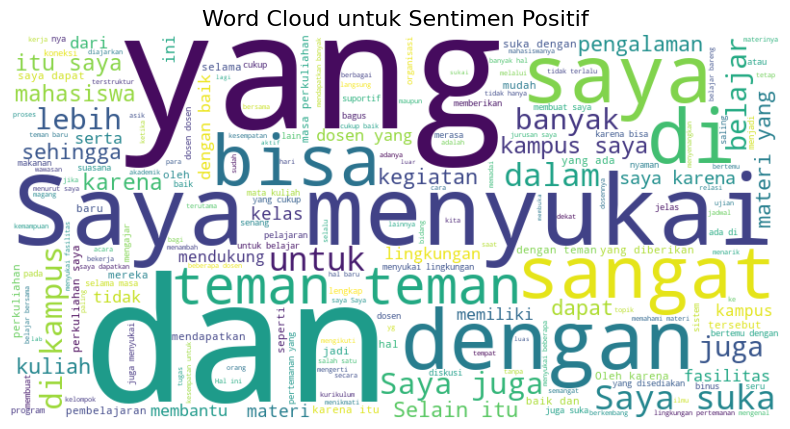

In [21]:
combined_text = ' '.join(df_preprocess[df_preprocess['sentiment'] == 'positive']['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Positif', fontsize=16)
plt.show()

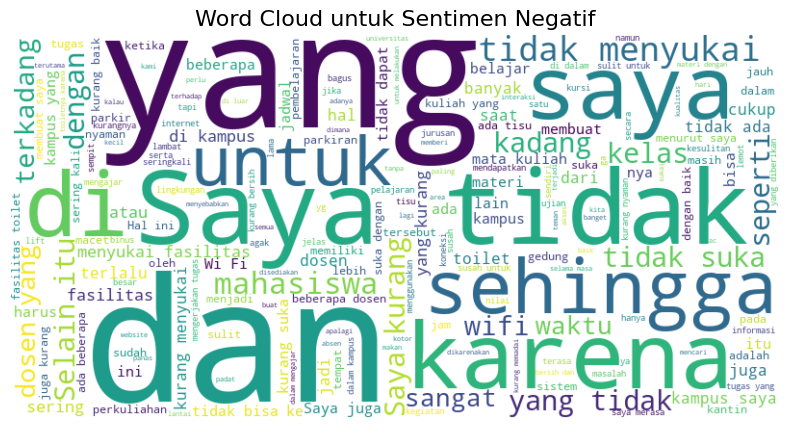

In [22]:
combined_text = ' '.join(df_preprocess[df_preprocess['sentiment'] == 'negative']['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Negatif', fontsize=16)
plt.show()

### **2. Frekuensi Kata**

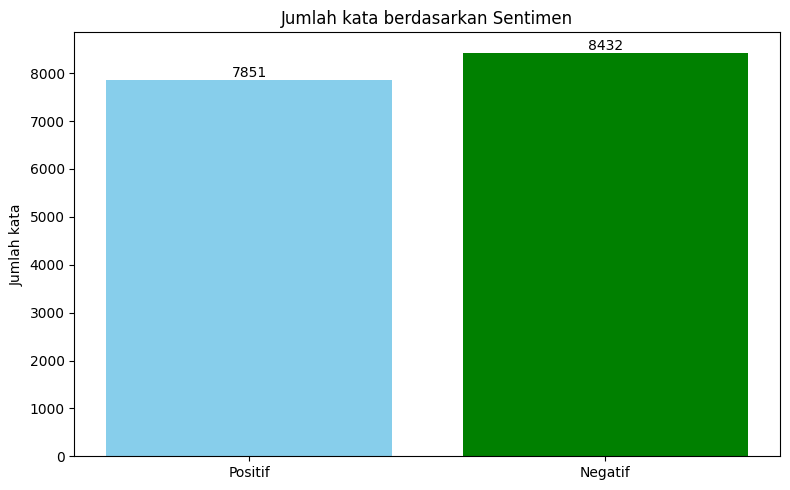

In [30]:
total_words = df_preprocess['word_count'].sum()
positive_words = df_preprocess[df_preprocess['sentiment'] == 'positive']['word_count'].sum()
negative_words = df_preprocess[df_preprocess['sentiment'] == 'negative']['word_count'].sum()

categories = ['Positif', 'Negatif']
word_counts = [positive_words, negative_words]

plt.figure(figsize=(8, 5))
bars = plt.bar(categories, word_counts, color=['skyblue', 'green'])
plt.ylabel('Jumlah kata')
plt.title('Jumlah kata berdasarkan Sentimen')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

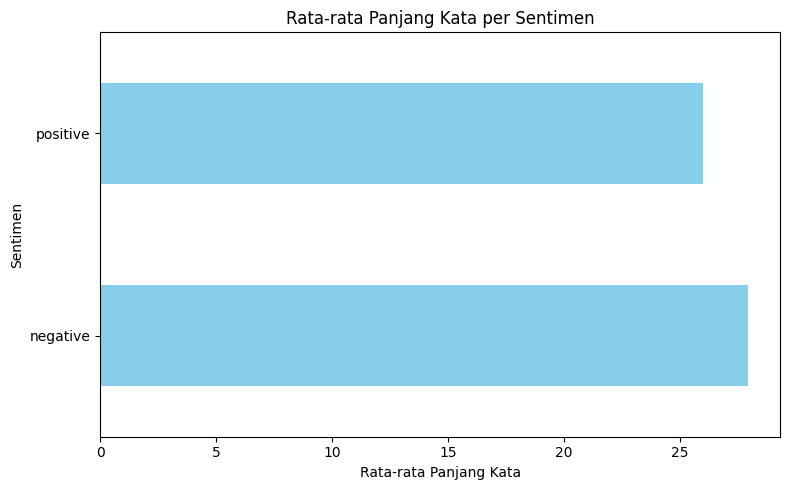

In [31]:
average_length = df_preprocess.groupby('sentiment')['word_count'].mean()

plt.figure(figsize=(8, 5))
average_length.plot(kind='barh', color='skyblue')
plt.title('Rata-rata Panjang Kata per Sentimen')
plt.ylabel('Sentimen')
plt.xlabel('Rata-rata Panjang Kata')
plt.tight_layout()
plt.show()

Jumlah kata pada sentimen negatif lebih tinggi daripada sentimen positif. Fenomena ini dapat dijelaskan melalui konsep negativity bias, yaitu kecenderungan individu untuk lebih fokus dan mengingat pengalaman negatif dibandingkan pengalaman positif. Karena itu, mahasiswa cenderung mengungkapkan pendapatnya lebih panjang ketika membagikan pengalaman negatif.

In [32]:
all_words = ' '.join(df_preprocess['text']).split()
positive_words = ' '.join(df_preprocess[df_preprocess['sentiment'] == 'positive']['text']).split()
negative_words = ' '.join(df_preprocess[df_preprocess['sentiment'] == 'negative']['text']).split()

top_all = Counter(all_words).most_common(10)
top_positive = Counter(positive_words).most_common(10)
top_negative = Counter(negative_words).most_common(10)

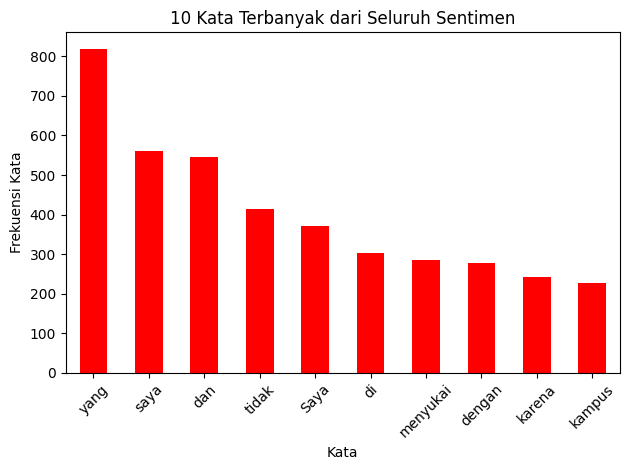

In [33]:
df_all = pd.DataFrame(top_all, columns=['word', 'count'])
df_all.plot(kind='bar', x='word', y='count', legend=False, color='red', title='10 Kata Terbanyak dari Seluruh Sentimen')
plt.ylabel('Frekuensi Kata')
plt.xlabel('Kata')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

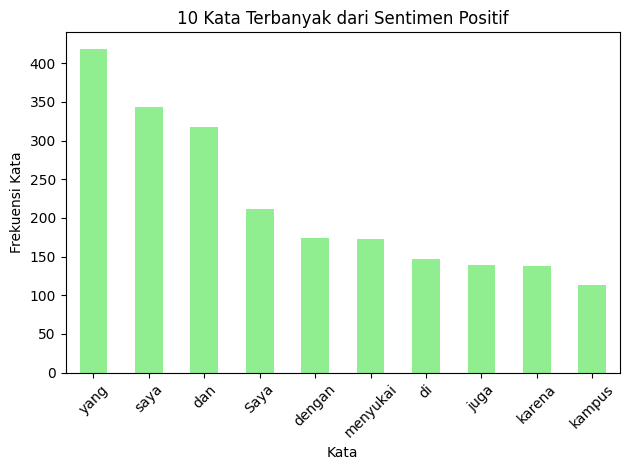

In [34]:
# Positive
pd.DataFrame(top_positive, columns=['word', 'count']).plot(kind='bar', x='word', y='count',
    legend=False, color='lightgreen', title='10 Kata Terbanyak dari Sentimen Positif')
plt.ylabel('Frekuensi Kata')
plt.xlabel('Kata')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

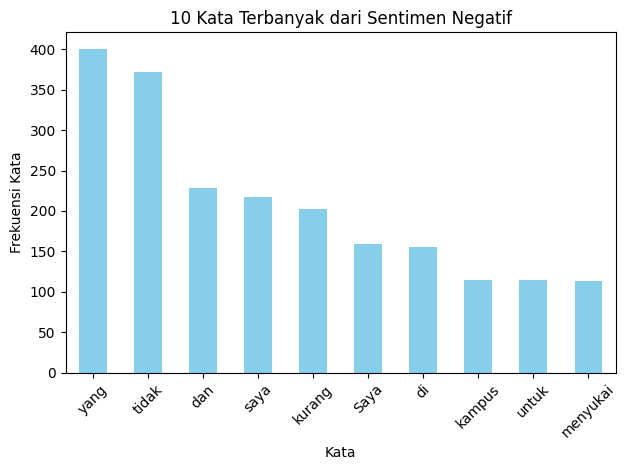

In [35]:
# Negative
pd.DataFrame(top_negative, columns=['word', 'count']).plot(kind='bar', x='word', y='count',
    legend=False, color='skyblue', title='10 Kata Terbanyak dari Sentimen Negatif')
plt.ylabel('Frekuensi Kata')
plt.xlabel('Kata')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Data Cleansing**

In [36]:
from src.dictionary.normalization_dictionary import norm_dict # Dictionary untuk memperbaiki typo dan singkatan

def correct_typos(text):
    for typo, correction in norm_dict.items():
        text = re.sub(typo, correction, text, flags=re.IGNORECASE)
    return text

# Contoh: "Saya sukaaaa sekali dengan kampus saya" -> "Saya suka sekali dengan kampus saya"
def reduce_extra_characters(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

exception_words = ["tanya", 'punya', 'bertanya', 'hanya'] # Kata-kata yang berakhiran dengan -nya namun memiliki arti sendiri
def split_nya(word):
    if word in exception_words:
        return word
    return re.sub(r'(.*?)nya$', r'\1 nya', word)

def process_split_nya(review):
    words = review.split()
    processed_words = [split_nya(word.strip()) for word in words]
    return ' '.join(processed_words)

In [37]:
def text_cleansing(text):
    text = text.lower() # Mengubah ke huruf kecil
    text = re.sub(r"[^a-zA-Z\s']", ' ', text) # Menghapus simbol dan angka
    text = process_split_nya(text) # Memisahkan kata dengan akhiran -nya
    text = correct_typos(text) # Memperbaiki typo dan huruf yang berlebih
    text = reduce_extra_characters(text) # Menghapus karaketer yang digunakan berulang-ulang
    text = re.sub(r'\s+', ' ', text).strip() # Menghapus spasi yang berlebih
    return text

In [38]:
df_preprocess['cleaned_text'] = df_preprocess['text'].apply(text_cleansing)

### **Wordcloud setelah text cleansing**

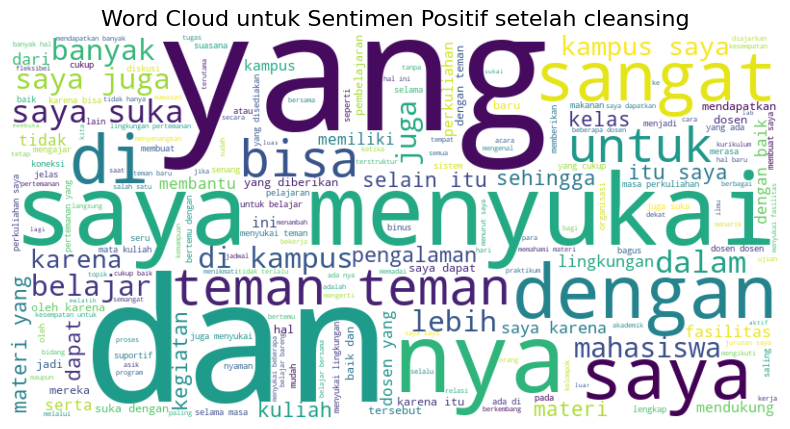

In [39]:
plot_wordcloud(
    df=df_preprocess, 
    sentiment='positive', 
    column_name='cleaned_text', 
    plot_title='Word Cloud untuk Sentimen Positif setelah cleansing'
)

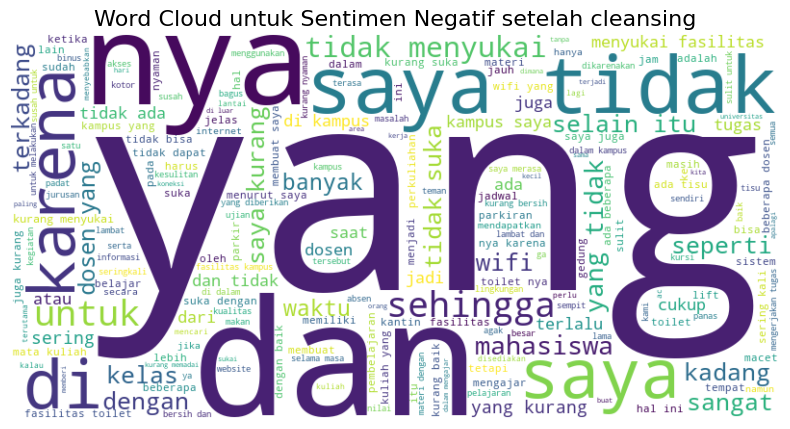

In [43]:
plot_wordcloud(
    df=df_preprocess, 
    sentiment='negative', 
    column_name='cleaned_text', 
    plot_title='Word Cloud untuk Sentimen Negatif setelah cleansing'
)

# **Data Preprocessing**

**Hasil dari tahap data preprocessing hanya akan digunakan untuk model SVM.**

In [44]:
def split_data(df, validation_data=False):
    if validation_data:
        train_df, val_test_df = train_test_split(
            df, test_size=0.2, random_state=42, stratify=df['sentiment']
        )
        val_df, test_df = train_test_split(
            val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['sentiment']
        )

        print(f'Training shape: {train_df.shape}')
        print(f'Validation shape: {val_df.shape}')
        print(f'Test shape: {test_df.shape}')
        return train_df, val_df, test_df

    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df['sentiment']
    )
    print(f'Training shape: {train_df.shape}')
    print(f'Test shape: {test_df.shape}')
    return train_df, test_df

In [45]:
df_train, df_test = split_data(df_preprocess[['cleaned_text', 'sentiment']], validation_data=False)

Training shape: (483, 2)
Test shape: (121, 2)


## Menghapus stopwords dan lematisasi dengan library **nlp_id**

In [ ]:
from src.dictionary.exclude_words import exclude_lemmatization, exclude_stopwords

lemmatizer = Lemmatizer()
tokenizer = Tokenizer()
stopword = StopWord()

# Menambahkan kata untuk stop words
stop_words = stopword.get_stopword()
custom_stopwords = ['nya', 'ya', 'nih']
stop_words.append(custom_stopwords)

def text_preprocessing_nlpid(text):
    tokens = tokenizer.tokenize(text)
    lemmatized_tokens = [
        lemmatizer.lemmatize(word) if (word not in exclude_stopwords and word not in exclude_lemmatization) else word
        for word in tokens
        if word not in stop_words or word in exclude_stopwords
    ]
    processed_text = re.sub(r'\s+', ' ', ' '.join(lemmatized_tokens)).strip()
    return processed_text

In [ ]:
sample_text = "Fasilitas kampus Alam Sutera sangat bagus Pelajaran lab diajarkan oleh asisten yang sangat mengerti materi"
print("Sample text:", sample_text)

processed_tokens = text_preprocessing_nlpid(sample_text)
print("Processed Tokens:", processed_tokens)

Sample text: Fasilitas kampus Alam Sutera sangat bagus Pelajaran lab diajarkan oleh asisten yang sangat mengerti materi
Processed Tokens: fasilitas kampus alam sutera bagus ajar lab ajar asisten erti materi


In [ ]:
df_train['cleaned_text_nlpid'] = df_train['cleaned_text'].apply(text_preprocessing_nlpid)
df_test['cleaned_text_nlpid'] = df_test['cleaned_text'].apply(text_preprocessing_nlpid)

## Menghapus stopwords dengan library **Sastrawi** dan lematisasi dengan library **Stana**


In [51]:
from src.dictionary.exclude_words import exclude_lemmatization, exclude_stopwords

stanza.download('id')
nlp = stanza.Pipeline(lang='id', processors='tokenize,mwt,pos,lemma')

factory = StopWordRemoverFactory()
sastrawi_stopwords = set(factory.get_stop_words())
custom_stopwords = {'nya', 'ya', 'nih'}
all_stopwords = sastrawi_stopwords.union(custom_stopwords)

def text_preprocessing_stanza_sastrawi(text):
    doc = nlp(text)

    lemmatized_tokens = []
    for sentence in doc.sentences:
        for word in sentence.words:
            token = word.text.lower()
            lemma = word.lemma.lower()
            if token in exclude_stopwords or token not in all_stopwords:
                lemmatized_token = token if token in exclude_lemmatization else lemma
                lemmatized_tokens.append(lemmatized_token)
    cleaned_text = re.sub(r'\s+', ' ', ' '.join(lemmatized_tokens)).strip()
    return cleaned_text

2025-12-27 16:45:04 INFO: Downloaded file to /Users/alicia.siahaya/stanza_resources/resources.json
2025-12-27 16:45:04 INFO: Downloading default packages for language: id (Indonesian) ...
2025-12-27 16:45:06 INFO: File exists: /Users/alicia.siahaya/stanza_resources/id/default.zip
2025-12-27 16:45:11 INFO: Finished downloading models and saved to /Users/alicia.siahaya/stanza_resources
2025-12-27 16:45:11 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-12-27 16:45:11 INFO: Downloaded file to /Users/alicia.siahaya/stanza_resources/resources.json
2025-12-27 16:45:12 INFO: Loading these models for language: id (Indonesian):
| Processor | Package      |
----------------------------
| tokenize  | gsd          |
| mwt       | gsd          |
| pos       | gsd_charlm   |
| lemma     | gsd_nocharlm |

2025-12-27 16:45:12 INFO: Using device: cpu
2025-12-27 16:45:12 INFO: Loading: tokenize
2025-12-27 16:45:12 INFO: Loading: mwt
2025-12-27 16:45:12 INFO: Loading: pos
2025-12-27 16:45:17 INFO: Loading: lemma
2025-12-27 16:45:18 INFO: Done loading processors!


In [ ]:
sample_text = "Fasilitas kampus Alam Sutera sangat bagus Pelajaran lab diajarkan oleh asisten yang sangat mengerti materi"
print("Sample text:", sample_text)

processed_tokens = text_preprocessing_stanza_sastrawi(sample_text)
print("Processed Tokens:", processed_tokens)

Sample text: Fasilitas kampus Alam Sutera sangat bagus Pelajaran lab diajarkan oleh asisten yang sangat mengerti materi
Processed Tokens: fasilitas kampus alam sutera sangat bagus pelajaran lab ajar asisten sangat mengerti materi


In [52]:
df_train['cleaned_text_stanza_sastrawi'] = df_train['cleaned_text'].apply(text_preprocessing_stanza_sastrawi)
df_test['cleaned_text_stanza_sastrawi'] = df_test['cleaned_text'].apply(text_preprocessing_stanza_sastrawi)

# **EDA after preprocessing**

In [53]:
df_preprocess['word_count_cleaned'] = df_preprocess['cleaned_text'].apply(lambda x: len(str(x).split()))

mean_word_count = df_preprocess['word_count_cleaned'].mean()
print("Rata-rata jumlah kata per ulasan:", mean_word_count)

Rata-rata jumlah kata per ulasan: 27.695364238410598


In [54]:
mean_word_count = df_preprocess.groupby('sentiment')['word_count_cleaned'].mean()
print("Rata-rata jumlah kata per", mean_word_count)

Rata-rata jumlah kata per sentiment
negative    28.589404
positive    26.801325
Name: word_count_cleaned, dtype: float64


In [55]:
all_words = [word for tokens in df_preprocess['cleaned_text'] for word in tokens]

unique_words = set(all_words)
num_unique_words = len(unique_words)

print(f"Jumlah kata unik: {num_unique_words}")

Jumlah kata unik: 28


### **Wordcloud setelah data cleansing dan preprocessing**

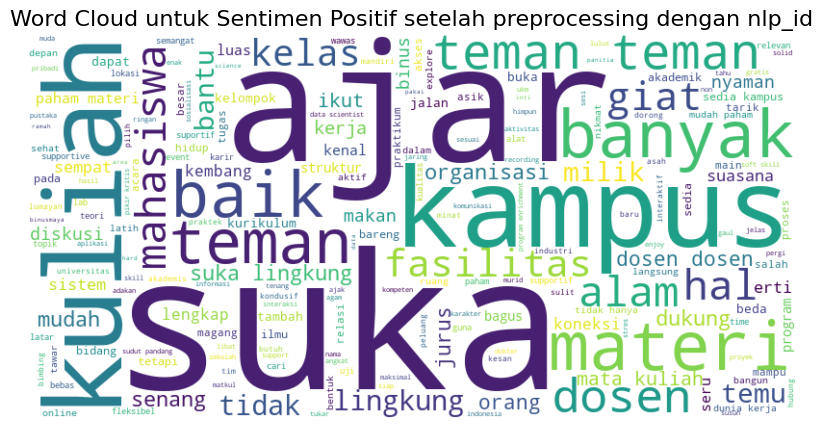

In [57]:
plot_wordcloud(
    df=df_train, 
    sentiment='positive', 
    column_name='cleaned_text_nlpid', 
    plot_title='Word Cloud untuk Sentimen Positif setelah preprocessing dengan nlp_id'
)

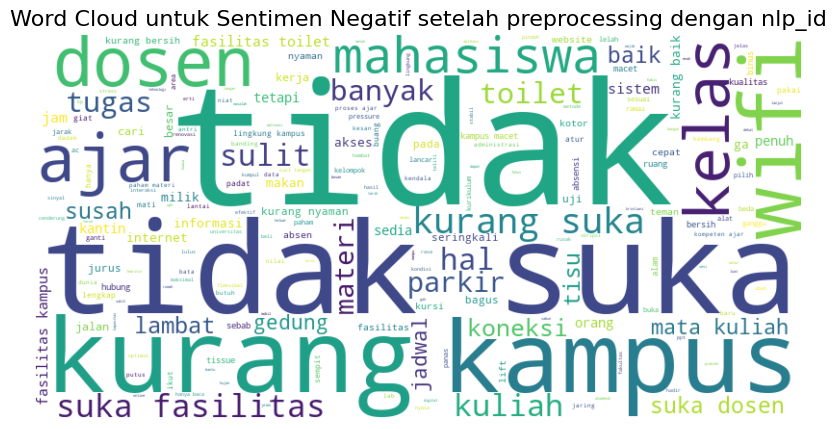

In [58]:
plot_wordcloud(
    df=df_train, 
    sentiment='negative', 
    column_name='cleaned_text_nlpid', 
    plot_title='Word Cloud untuk Sentimen Negatif setelah preprocessing dengan nlp_id'
)

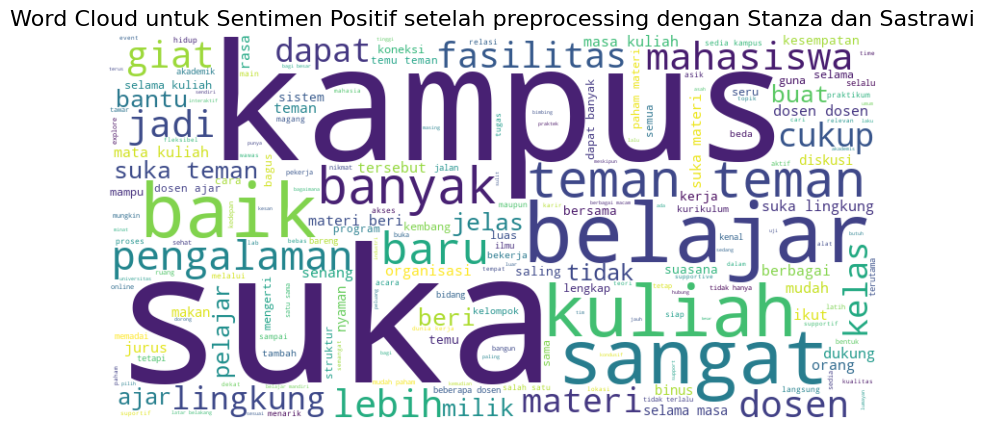

In [59]:
plot_wordcloud(
    df=df_train, 
    sentiment='positive', 
    column_name='cleaned_text_stanza_sastrawi', 
    plot_title='Word Cloud untuk Sentimen Positif setelah preprocessing dengan Stanza dan Sastrawi'
)

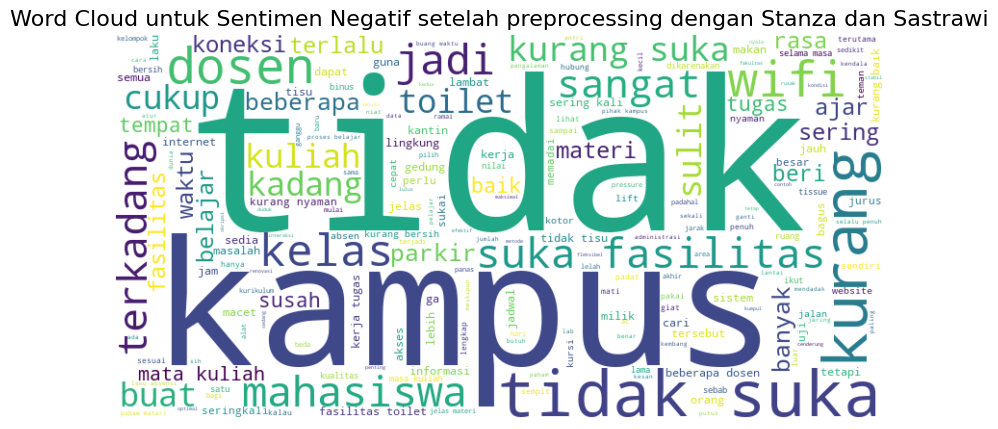

In [60]:
plot_wordcloud(
    df=df_train, 
    sentiment='negative', 
    column_name='cleaned_text_stanza_sastrawi', 
    plot_title='Word Cloud untuk Sentimen Negatif setelah preprocessing dengan Stanza dan Sastrawi'
)

# **Menyimpan hasil preprocessing**

1. Data yang hanya melalui text cleansing akan digunakan untuk IndoBERT
2. Data yang melalui text cleansing dan text preprocessing akan digunakan untuk SVM, dimana terdapat 2 data sesuai dengan library preprocessing yang digunakan: 

    a. Preprocessing dengan nlp_id

    b. Preprocessing dengan Stanza dan Sastrawi

In [ ]:
df_preprocess[['cleaned_text', 'sentiment']].to_csv('./src/data/df_modeling_BERT.csv', index=False)

In [ ]:
df_train[['cleaned_text_nlpid', 'sentiment']].to_csv("./src/data/df_train.csv", index=False)
df_test[['cleaned_text_nlpid', 'sentiment']].to_csv("./src/data/df_test.csv", index=False)

In [ ]:
df_train[['cleaned_text_stanza_sastrawi', 'sentiment']].to_csv("./src/data/df_train2.csv", index=False)
df_test[['cleaned_text_stanza_sastrawi', 'sentiment']].to_csv("./src/data/df_test2.csv", index=False)